Set up Colab requirements if in Colab, or autoreload if in jupyter

In [48]:
try: # test if running from colab
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    %cd /content
    !rm -rf gps-lane-changes
    !git clone https://github.com/tomdries/gps-lane-changes
    %cd gps-lane-changes
else:
    %load_ext autoreload 
    %autoreload 2
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import pandas as pd
from pathlib import Path
import dataloaders
import matplotlib.pyplot as plt
import numpy as np
from analysis_helpers import *



In [165]:
lca_dfs, trip_dfs, trip_names, road_dfs = dataloaders.load_data()

As direction calculation can get quite noisy at low speeds, we remove driving under 30 km/h. 

<IPython.core.display.Javascript object>


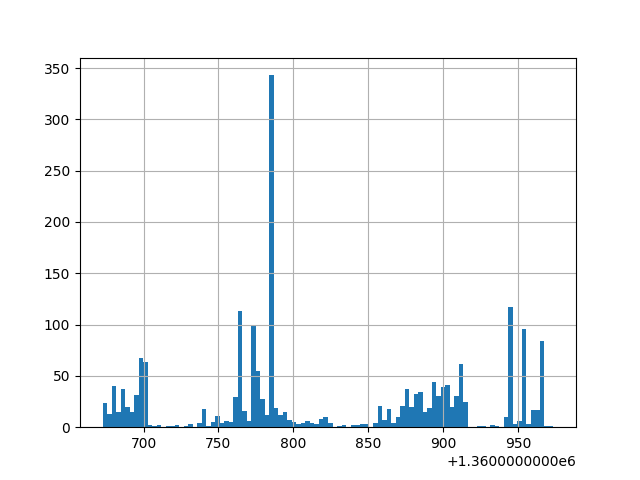

<AxesSubplot:>

In [171]:
df = trip_dfs[0][0]
plt.subplots()
df.bearing_road.hist(bins=100)

# Calculate offset and append to all dataframes
This only needs to run once, so uncommented.

In [ ]:
from calculate_offset import batch_append_offset
trip_dfs_out  = batch_append_offset(trip_dfs, trip_names, road_dfs)

In [ ]:
trip_dfs_out[0][0]

# Create labeled time windows

Select trip and device

In [134]:
trip_dfs[2][1].section.unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M'],
      dtype=object)

<img src="figures/sections.jpg" width=180 height=250 />

In [ ]:
# select trip and device
trip_nr = 2
dev_nr = 1
sections = 'all'#['A', 'M']

trip_df, lca_df, trip_name = selector(trip_dfs, lca_dfs, trip_names, trip_nr, dev_nr, sections)
print(trip_name)

Calculate signals

In [ ]:
trip_df['lat_vel'] = derivative(trip_df.t, trip_df['offset'])

from config import EWM_SPAN
trip_df['offset_ewmfilt'] = trip_df.offset.ewm(span=EWM_SPAN).mean()
trip_df['lat_vel_ewmfilt'] = derivative(trip_df.t, trip_df['offset_ewmfilt'])

trip_df['bearing_diff'] = (trip_df.bearing_gps - trip_df.bearing_road) * np.pi/180
trip_df['proj_lat_dist'] = np.sin(bearing_diff)*trip_df.distance_gps

trip_df['bearing_diff_ewmfilt'] = bearing_diff.ewm(span=EWM_SPAN).mean()
trip_df['proj_lat_dist_ewmfilt_sine'] = np.sin(bearing_diff_ewmfilt) * trip_df.distance_gps

trip_df['proj_lat_dist_ewmfilt'] = bearing_diff_ewmfilt * trip_df.distance_gps

In [ ]:
trip_df.bearing_road

In [ ]:
window_size = 20
plot_col = 'proj_lat_dist_ewmfilt_sine'#lat_vel_ewmfilt''

lca_df['t0_w'] = lca_df.t_lc-(window_size/2)
lca_df['t_end_w'] = lca_df.t_lc+(window_size/2)
fragment_dfs_left = []
fragment_dfs_right = []
fig,axs=plt.subplots(2)
for i, lca_df_row in lca_df.iterrows():
    if lca_df_row.direction == 'left':
        
        fragment_df = trip_df[trip_df.t.between(lca_df_row.t0_w, lca_df_row.t_end_w)]
        axs[0].plot(fragment_df.t - lca_df_row.t0_w, fragment_df[plot_col], color='black', alpha=.2)
        axs[0].title.set_text('left')
    elif lca_df_row.direction == 'right':
        fragment_df = trip_df[trip_df.t.between(lca_df_row.t0_w, lca_df_row.t_end_w)]
        axs[1].plot(fragment_df.t - lca_df_row.t0_w, fragment_df[plot_col], color='black', alpha=.2)
        axs[1].title.set_text('right')
        
plt.tight_layout()    

<IPython.core.display.Javascript object>


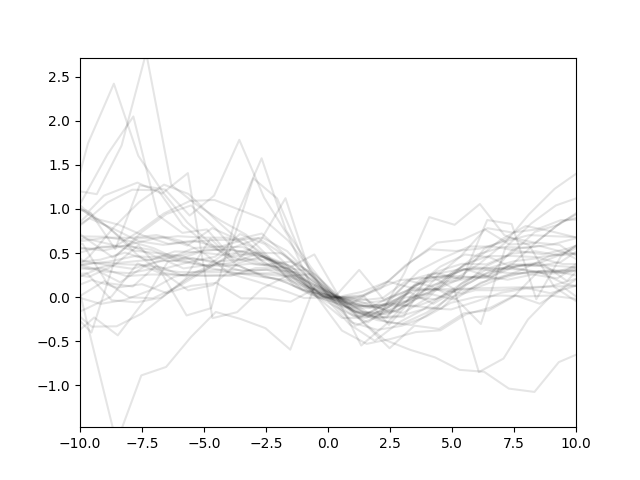

In [126]:
def plot_lane_change_fragments(lca_df, trip_df, column, xlims, ylims=None):
    fig,ax=plt.subplots()
    for t_lc in lca_df.t_lc:
        value_in_middle = trip_df.iloc[abs((trip_df.t - t_lc)).argmin()][column]
        plt.plot(trip_df.t - t_lc, trip_df[column] - value_in_middle, alpha = 0.1, color = 'black')
        plt.xlim(xlims)
        plt.ylim(ylims)


plot_lane_change_fragments(lca_df[lca_df.direction=='left'], trip_df, 'lat_vel_ewmfilt', xlims=(-10,10
                                                                                               ))
    
    

In [ ]:
trip_df